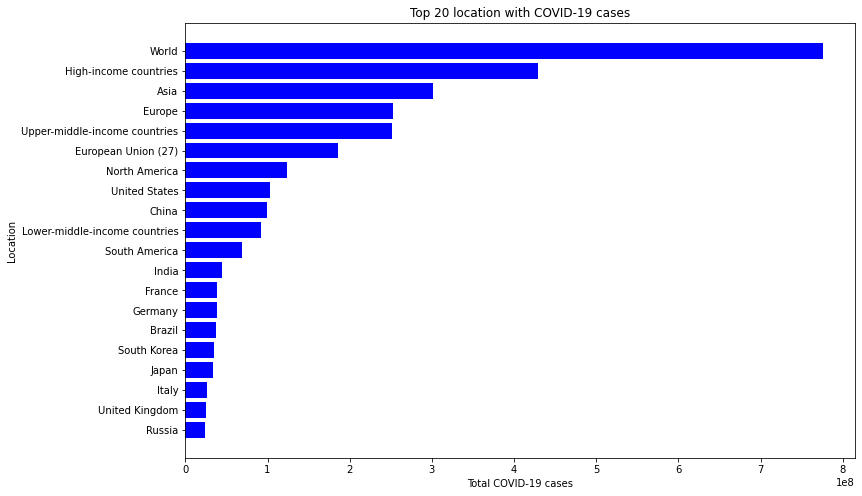

DataFrame[location: string, country_code: string, total_cases: string, continent: string, total_deaths: double, median_age: double, gdp_per_capita: double, cardiovasc_death_rate: double, diabetes_prevalence: double, life_expectancy: double, population: string, Death_Rate(%): double]
+--------------------+------------+-----------+-------------+------------+----------+--------------+---------------------+-------------------+---------------+----------+-------------+
|            location|country_code|total_cases|    continent|total_deaths|median_age|gdp_per_capita|cardiovasc_death_rate|diabetes_prevalence|life_expectancy|population|Death_Rate(%)|
+--------------------+------------+-----------+-------------+------------+----------+--------------+---------------------+-------------------+---------------+----------+-------------+
|               World|    OWID_WRL|   7.76e+08|      UNKNOWN|   7057132.0|      30.9|     15469.207|               233.07|               8.51|          72.58|  7.98

In [0]:
# Import Libraries
import json
import requests
import warnings
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, format_string, round

warnings.simplefilter(action='ignore', category=Warning)

log_file = 'log_file.txt'

# Extract covid-19_data from API
def extract_covid_19_data(url):
    #url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/latest/owid-covid-latest.json"
    response = requests.get(url)
    if response.status_code ==200:
        data = response.json()

        #Convert dictionary to DataFrame
        df = pd.DataFrame.from_dict(data, orient = 'index')
        return df

    else:
        raise Exception('Failed to fetch data from API')

# Transform covid-19_data    
def transform_covid_19_data(df):

    # Reset Index and Rename column
    df = df.reset_index().\
        rename(columns = {'index':'country_code'})            

    # Drop columns with missing values that are less than 50% 'df.count()'
    count = 247 // 2
    df = df.dropna(axis=1, thresh = count)

    # Convert Pandas DataFrame to Spark DataFrame
    spark = SparkSession.builder.appName('covid_data').getOrCreate()
    sdf  = spark.createDataFrame(df)

    # Specific columns selected
    columns = ['location','country_code', 'total_cases', 'continent', 
                'total_deaths', 'median_age', 'gdp_per_capita', 'cardiovasc_death_rate',
                 'diabetes_prevalence','life_expectancy', 'population']
    sdf = sdf.select(*columns)

    # Fill 'null' values with '0' and empty string with 'unknown'
    sdf = sdf.fillna(0)
    sdf = sdf.fillna({'country_code':'UNKNOWN', 'continent':'UNKNOWN', 'location':'UNKNOWN'})

    # Move column 'location' to first position
    new_column_order = ['location'] + [col for col in sdf.columns if col != 'location']
    sdf = sdf.select(new_column_order)

    # Calculate Case fatality rate (CFR) or 'Death Rate'.
    sdf = sdf.withColumn(
        'Death_Rate(%)', when(col('total_cases') == 0, 0).otherwise((col('total_deaths')/col('total_cases')) * 100)
    )

    # Remove duplicates
    sdf = sdf.dropDuplicates()

    # Sort the columns by 'total_cases'
    sdf = sdf.orderBy('total_cases', ascending = False)

    # Loop through each specified column and format its values in scientific notation (2 decimal places)
    columns = ['total_cases', 'population']
    for cols in columns:
        sdf = sdf.withColumn(
            cols, format_string('%.2e', col(cols))
        )

    # Round 'Death_Rate(%)' into 2 signifiacnt fig
    sdf = sdf.withColumn('Death_Rate(%)',
                     round(col('Death_Rate(%)'), 2))
    
    return sdf

# Visualize 'location' vs 'total_cases'
# Convert Spark DataFrame to Pandas for plotting
plot_df = transformation.select('location', 'total_cases').toPandas()

# Convert 'total_cases from 'scientific notation' to 'float'
plot_df['total_cases'] = plot_df['total_cases'].astype(float)

# select top 20 countries with highest covid-19 cases
plot_df = plot_df.sort_values(by = 'total_cases', ascending = False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(plot_df['location'], plot_df['total_cases'], color = 'blue')
plt.xlabel('Total COVID-19 cases')
plt.ylabel('Location')
plt.title('Top 20 location with COVID-19 cases')   
plt.gca().invert_yaxis() 
plt.show()

# Save tranformed dataset to a CSV file in Databricks
def load_covid_19_data(sdf):
    sdf.write.option('header', True).mode('overwrite').csv('/dbfs/tmp/data/cleaned_covid_19_data')

# Log ETL progress
def log_progress(message):
    # 'Year-month-day Hour:Minute:Second'
    timestamp_format = '%Y-%m-%d %H:%M:%S'
    # current timestamp
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open(log_file, 'a') as f:
        f.write(timestamp + ',' + message + '\n')
     
# Log the initialization of the ETL process 
log_progress('ETL process started')

# Log the beginning of data extration
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/latest/owid-covid-latest.json"
log_progress('Extraction phase started')
extraction = extract_covid_19_data(url)

# Log the end of data extraction
log_progress('Extraction phase ended')

# Log the beginning of data Tranformation
log_progress('Transformation phase started')

transformation = transform_covid_19_data(extraction)
print(transformation)

# Log the ending of data Tranformation
log_progress('Transformation phase ended')

# Log the beginning of data loading
log_progress('Loading phase started')
loading = load_covid_19_data(transformation)

# Log the ending of data loading
log_progress('Loading phase ended')

# Log the completion of ETL process
log_progress('ETL process ended')

transformation.show()

# View log_file
with open(log_file, 'r') as f:
    logs = f.read()
    print(logs)

 
